# Boltzmann Machine Implementation
This code demonstrates a simple implementation of a Boltzmann Machine model.

1. Create a Copy of this into your Drive
2. Download the dataset here (https://drive.google.com/drive/folders/1eAEJihKqQmwgciVb42D6zwRyi6AYCYCJ?usp=drive_link)
3. Upload it to your runtime
4. Set dataset_directory to the path where the dataset folder is
5. Run the blocks in sequence


If you have access to the shared drive:
Mount drive containing dataset found here (https://drive.google.com/drive/folders/1eAEJihKqQmwgciVb42D6zwRyi6AYCYCJ?usp=drive_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check if files can be read
import os
print(os.listdir('/content/drive/Shareddrives/CMSC 191/CMSC 191 GenAI Datasets/Mango Preprocessed'))

['0001_0045_flip_both_12.jpg', '0001_0045_flip_horizontal_11.jpg', '0001_0045_rotate_45_9.jpg', '0001_0045_brightness_+50_15.jpg', '0001_0045_rotate_0_8.jpg', '0001_0045_flip_vertical_10.jpg', '0001_0045_brightness_-50_13.jpg', '0001_0045_noise_50_18.jpg', '0001_0045_noise_10_16.jpg', '0001_0045_noise_25_17.jpg', '0001_0046_scale_0.5_4.jpg', '0001_0046_blur_7_3.jpg', '0001_0046_blur_3_1.jpg', '0001_0046_blur_5_2.jpg', '0001_0046_rotate_-45_7.jpg', '0001_0046_flip_vertical_10.jpg', '0001_0046_rotate_0_8.jpg', '0001_0046_rotate_45_9.jpg', '0001_0046_scale_1.5_6.jpg', '0001_0046_flip_horizontal_11.jpg', '0001_0046_scale_1.0_5.jpg', '0001_0046_flip_both_12.jpg', '0001_0046_noise_25_17.jpg', '0001_0046_brightness_+50_15.jpg', '0001_0046_noise_10_16.jpg', '0001_0046_brightness_+0_14.jpg', '0001_0046_brightness_-50_13.jpg', '0001_0046_noise_50_18.jpg', '0001_0047_blur_7_3.jpg', '0001_0047_blur_3_1.jpg', '0001_0047_scale_0.5_4.jpg', '0001_0047_rotate_-45_7.jpg', '0001_0047_scale_1.0_5.jpg', '0

This section imports the necessary libraries. numpy is used for numerical operations, matplotlib.pyplot is used for plotting images, and tensorflow for some image processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.image import rgb_to_grayscale

display_images() displays a list of images using Matplotlib. Each image is reshaped back to its original dimensions for proper visualization.

In [ ]:
def display_images(images, type):
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        if(type == "gray"):
          plt.imshow(img.reshape(32, 32), cmap='gray')
        if(type == "rgb"):
          plt.imshow(img.reshape(32, 32, 3), cmap='gray')
        plt.axis('off')
    plt.show()

Retrieve Images and turn into TensorSpecs, then a numpy array

In [ ]:
# Load the dataset using tf.keras.preprocessing.image_dataset_from_directory
dataset_directory = '/content/drive/Shareddrives/CMSC 191/CMSC 191 GenAI Datasets/'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    labels='inferred',
    label_mode='int',
    image_size=(32, 32),  # Adjust image size if needed
    interpolation='nearest',
    batch_size=32, # with 32, there will be 51 batches for the 1620 images
    shuffle=True
)

# Convert the dataset to NumPy arrays
images = []
# labels = []
for batch in dataset:
    images.extend(batch[0].numpy())
    # labels.extend(batch[1].numpy())

images = np.array(images)
print(images.shape)
# labels = np.array(labels)
# print(labels.shape)

Found 1620 files belonging to 1 classes.
(1620, 32, 32, 3)


Binarization over a green hue

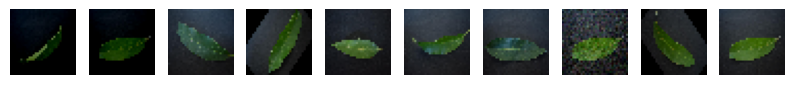

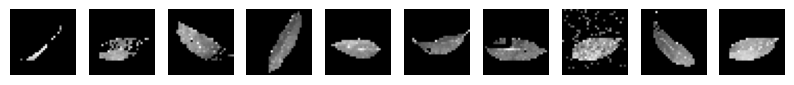

In [ ]:
# def preprocess_images(images):
#     images = rgb_to_grayscale(images)
#     images = np.where(images > 70, 1, 0)
#     return images
import cv2

def preprocess_images(images):
    binarized_images = []
    for img in images:
        img_hsv = cv2.cvtColor(img.astype("uint8"), cv2.COLOR_RGB2HSV)
        # Define range of green color in HSV
        lower_green = np.array([30, 50, 50])  # Adjust lower bound
        upper_green = np.array([90, 255, 255])  # Adjust upper bound
        # Threshold the HSV image to get only green colors
        mask = cv2.inRange(img_hsv, lower_green, upper_green)
        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(img.astype("uint8"), img.astype("uint8"), mask=mask)
        # Convert to grayscale and binarize
        gray = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        # _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        # binarized_images.append(binary)
        scaled_img = gray / 255.0 # normalization
        binarized_images.append(scaled_img)
    return np.array(binarized_images)

display_images(images[:10], "rgb") # just to check if it's being converted into numpy arrays properly
binarized_images = preprocess_images(images)
display_images(binarized_images[:10], "gray") #

Set training data

In [ ]:
training_data = binarized_images


The code below shows the constructor of the BoltzmannMachine class. It initializes the number of visible units and creates a weight matrix with small random values. The diagonal of the weight matrix is set to zero to avoid self-connections.

In [ ]:
import time

class BoltzmannMachine:
    def __init__(self, num_visible):
        self.num_visible = num_visible
        # self.weights = np.random.randn(num_visible, num_visible) * 0.1

        # Xavier initialization for weights
        self.weights = np.random.uniform(
            low=-np.sqrt(6.0 / (num_visible + num_visible)),  # Adjust for sigmoid
            high=np.sqrt(6.0 / (num_visible + num_visible)),
            size=(num_visible, num_visible)
        )

        np.fill_diagonal(self.weights, 0)

        self.prev_weights = None  # Initialize to None ; for checking of weights

    def _sample(self, probabilities):
        return np.random.binomial(1, probabilities)

    def train(self, data, num_epochs=1000, learning_rate=0.1):
        weight_decay = 0.01
        start_time_total = time.time()  # Start time for total training
        # persistent_chain = np.random.rand(len(data[0].flatten())) < 0.5  # Initialize persistent chain


        for epoch in range(num_epochs):
            epoch_error = 0  # Initialize error for the epoch
            print(f"Epoch {epoch}")
            start_time_epoch = time.time()  # Start time for the epoch

            for pattern in data:
                pattern = pattern.flatten()  # Flatten the image
                # Positive phase
                pos_hidden_probs = self._sigmoid(np.dot(pattern, self.weights))
                pos_hidden_states = self._sample(pos_hidden_probs)

                # Negative phase
                neg_visible_probs = self._sigmoid(np.dot(pos_hidden_states, self.weights.T))
                neg_hidden_probs = self._sigmoid(np.dot(neg_visible_probs, self.weights))

                # Negative phase using persistent chain
                # neg_visible_probs = self._sigmoid(np.dot(persistent_chain, self.weights.T))
                # neg_hidden_probs = self._sigmoid(np.dot(neg_visible_probs, self.weights))
                # persistent_chain = self._sample(neg_visible_probs)  # Update persistent chain

                # Update weights
                # self.weights += learning_rate * (np.outer(pattern, pos_hidden_probs) -
                                                  # np.outer(neg_visible_probs, neg_hidden_probs))

                self.weights += learning_rate * (np.outer(pattern, pos_hidden_probs) - np.outer(neg_visible_probs, neg_hidden_probs)
                                - weight_decay * self.weights)  # Add weight decay term

                # Calculate reconstruction error for this pattern
                reconstruction = self._sigmoid(np.dot(pos_hidden_states, self.weights.T))
                error = np.sum((pattern - reconstruction)**2)
                epoch_error += error

            end_time_epoch = time.time()  # End time for the epoch
            epoch_time = end_time_epoch - start_time_epoch
            avg_epoch_error = epoch_error / len(data)
            # Calculate weight change
            if self.prev_weights is not None:
                weight_change = np.sum(np.abs(self.weights - self.prev_weights))
                print(f"Epoch {epoch} time: {epoch_time:.2f} seconds, Reconstruction Error: {avg_epoch_error:.4f}, Weight Change: {weight_change:.4f}")
            else:
                print(f"Epoch {epoch} time: {epoch_time:.2f} seconds, Reconstruction Error: {avg_epoch_error:.4f}")
            # print(f"Epoch {epoch} time: {epoch_time:.2f} seconds, Reconstruction Error: {avg_epoch_error:.4f}")
            # Update previous weights
            self.prev_weights = self.weights.copy()

        end_time_total = time.time()  # End time for total training
        total_time = end_time_total - start_time_total
        print(f"Total training time: {total_time:.2f} seconds")

    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)  # Clip x to the range [-500, 500]
        return 1 / (1 + np.exp(-x))

    def generate(self, num_samples=1):
        print(f"generating {num_samples} samples")
        samples = []
        i = 1
        for _ in range(num_samples):
            visible = np.random.rand(self.num_visible) < 0.5  # Start with random visible layer
            for _ in range(1000):  # Run Gibbs sampling
                hidden_probs = self._sigmoid(np.dot(visible, self.weights))
                hidden_states = self._sample(hidden_probs)
                visible_probs = self._sigmoid(np.dot(hidden_states, self.weights.T))
                visible = self._sample(visible_probs)
            samples.append(visible)
            print(f"sample {i} generated")
            i += 1
        return np.array(samples)



The _sample() method samples binary states (0 or 1) from a given probability distribution. It uses a binomial distribution.

The train() method trains the Boltzmann Machine using contrastive divergence. It consists of a positive phase (calculating hidden probabilities from visible patterns) and a negative phase (updating the weights based on reconstructions).

The sigmoid() method applies the sigmoid function, which squashes input values to the range (0, 1). It’s used to calculate probabilities.

This function below binarizes the input images by thresholding, converting pixel values greater than 127 to 1 and others to 0.

The generate() method generates new samples by running Gibbs sampling for a specified number of iterations. It starts with random visible states and iteratively updates them based on hidden states.

This section creates an instance of the Boltzmann Machine, trains it using the binary training images, and generates new samples.

In [ ]:
# Create and train the Boltzmann machine
# boltzmann = BoltzmannMachine(num_visible=32*32*3) # RGB
boltzmann = BoltzmannMachine(num_visible=32*32) # Grayscale

# 3. Train the Boltzmann Machine using the training_data
boltzmann.train(training_data, num_epochs=50, learning_rate=0.001)
# boltzmann.train(training_data, num_epochs=100, learning_rate=0.01)

# Generate new samples
generated_samples = boltzmann.generate(num_samples=10)

Epoch 0
Epoch 0 time: 27.26 seconds, Reconstruction Error: 11.0267
Epoch 1
Epoch 1 time: 27.06 seconds, Reconstruction Error: 8.3142, Weight Change: 1219.3198
Epoch 2
Epoch 2 time: 23.63 seconds, Reconstruction Error: 7.6371, Weight Change: 1243.7245
Epoch 3
Epoch 3 time: 24.25 seconds, Reconstruction Error: 7.1751, Weight Change: 1053.3576
Epoch 4
Epoch 4 time: 24.24 seconds, Reconstruction Error: 6.9039, Weight Change: 917.7025
Epoch 5
Epoch 5 time: 22.83 seconds, Reconstruction Error: 6.7333, Weight Change: 812.1431
Epoch 6
Epoch 6 time: 25.26 seconds, Reconstruction Error: 6.5874, Weight Change: 741.3931
Epoch 7
Epoch 7 time: 24.03 seconds, Reconstruction Error: 6.4604, Weight Change: 711.9660
Epoch 8
Epoch 8 time: 27.47 seconds, Reconstruction Error: 6.3961, Weight Change: 711.0090
Epoch 9
Epoch 9 time: 27.73 seconds, Reconstruction Error: 6.2689, Weight Change: 706.6723
Epoch 10
Epoch 10 time: 23.83 seconds, Reconstruction Error: 6.1668, Weight Change: 691.0331
Epoch 11
Epoch 11 

You can visualize the generated samples with the display function.

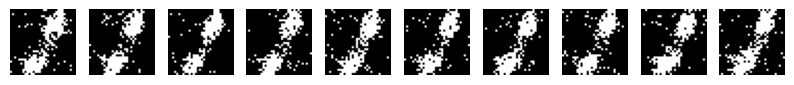

In [ ]:
# Display the generated samples
# display_images(generated_samples, "rgb")
display_images(generated_samples, "gray")



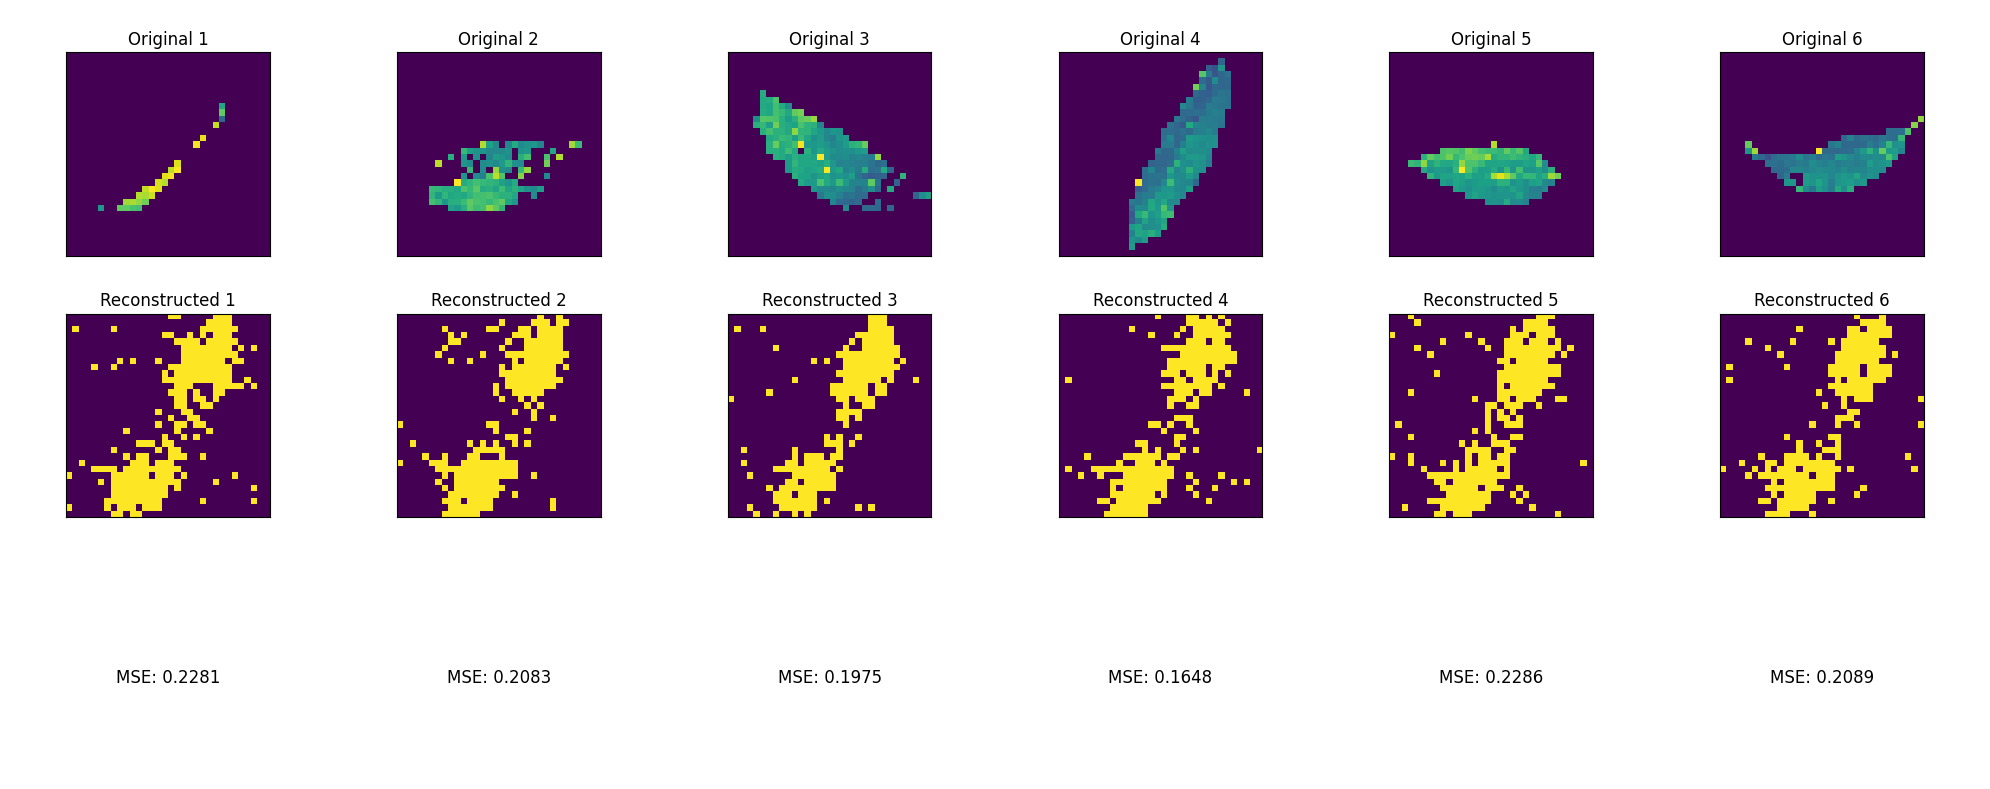

Image 1: MSE = 0.2281
Image 2: MSE = 0.2083
Image 3: MSE = 0.1975
Image 4: MSE = 0.1648
Image 5: MSE = 0.2286
Image 6: MSE = 0.2089

Average MSE: 0.2060


In [ ]:
# Number of images
n = 6

# Placeholder to store MSE values
mse_values = []

# Create a figure to display images
plt.figure(figsize=(20, 8))

for i in range(n):
    # Original image
    original = training_data[i].reshape(32, 32)  # Assuming x_test is the dataset
    # Reconstructed image
    reconstructed = generated_samples[i].reshape(32, 32)  # Assuming encoded_imgs are the reconstructions
    # no need to convert to grayscale
    # Compute MSE
    mse = np.mean((original - reconstructed) ** 2)
    mse_values.append(mse)

    # Display Original Image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original)
    plt.title(f"\nOriginal {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Reconstructed Image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed)
    plt.title(f"\nReconstructed {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display MSE Value
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.text(0.5, 0.5, f"MSE: {mse:.4f}", fontsize=12, ha='center', va='center')
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print MSE values for reference
for i, mse in enumerate(mse_values, 1):
    print(f"Image {i}: MSE = {mse:.4f}")

# Compute the average MSE across all images
average_mse = np.mean(mse_values)
print(f"\nAverage MSE: {average_mse:.4f}")